In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os

In [2]:
import operator
import numpy as np

class Grid2D(): 
    def __init__(self,x_dim,y_dim,cell_prob):
        self.grid = np.zeros((y_dim,x_dim))
        self.velocities = []
        
        k = 0
        for i in range(0,y_dim,20):
            for j in range(0,x_dim,20):
                if (np.random.random() < cell_prob):
                    k += 1
                    self.grid[i:i+20,j:j+20] = k
                    
        num_cells = int(self.grid.flatten().max())
        areas = []
        for i in range(1,num_cells+1):
            areas.append(self.get_area(self.grid,i))
        self.areas = areas
        
        self.num_cells = k
        
        perims = []
        for i in range(1,num_cells+1):
            perims.append(self.get_perimeter(self.grid,i))
            
        self.perims = perims
        
        self.cand_a = areas
        self.cand_p = perims
        
        self.boundary_grid = self.return_entire_boundary(self.grid)
            
    def _boundarize_grid(self, grid):
        boundaries = np.zeros(grid.shape)
        (i_inds,j_inds) = np.where(grid)
        boundary_points = []
        for i in range(len(i_inds)):
            if (i_inds[i] == 0 or i_inds[i] == grid.shape[0] - 1 or j_inds[i] == 0 or j_inds[i] == grid.shape[1] - 1):
                boundary_points.append([i_inds[i],j_inds[i]])
            neighborhood = grid[i_inds[i]-1:i_inds[i]+2,j_inds[i]-1:j_inds[i]+2]
            
            if ((neighborhood.flatten() == 0).any()):
                boundary_points.append([i_inds[i],j_inds[i]])                
        
        boundary_points = np.array(boundary_points)
        for x in boundary_points:
            boundaries[x[0],x[1]] = 1
        return boundaries
    
    def return_boundaries(self, grid, newgrid):
        
        diff_grid = grid - newgrid
        diff_inds = np.where(diff_grid != 0)
        
        diff_cells = grid[diff_inds]
        diff_cell_inds = np.where(diff_cells != 0)
        diff_cells = diff_cells[diff_cell_inds]
        
        new_diff_cells = newgrid[diff_inds]
        new_diff_cell_inds = np.where(new_diff_cells != 0)
        new_diff_cells = new_diff_cells[new_diff_cell_inds]
        
        diff_cells = np.unique(np.append(diff_cells,new_diff_cells))
        
        boundary_grid = np.zeros(grid.shape)
        for cell in diff_cells:
            boundary_i = grid == cell
            boundary_grid = np.add(boundary_grid, self._boundarize_grid(boundary_i))
        
        boundary_newgrid = np.zeros(grid.shape)
        for cell in diff_cells:
            boundary_i = newgrid == cell
            boundary_newgrid = np.add(boundary_newgrid, self._boundarize_grid(boundary_i))
                
        return np.append(boundary_grid,boundary_newgrid).flatten()
    
    def get_perimeter(self, grid, i):

        index_grid = grid == i
        i_inds,j_inds = np.where(index_grid)
        
        perim_pixels = 0
        for i in range(len(i_inds)):
            ind_1 = i_inds[i]
            ind_2 = j_inds[i]
            xv = np.array([ind_1-1,ind_1+1,ind_1,ind_1])
            yv = np.array([ind_2,ind_2,ind_2-1,ind_2+1])
            boundary_inds = np.logical_or(np.logical_or(np.logical_or(xv == -1, yv == -1), xv == self.grid.shape[0]), yv == self.grid.shape[1])
            
            for j in range(len(boundary_inds)):
                if(boundary_inds[j] == True):
                    perim_pixels += 1
                    
            boundary_inds_inv = list(map(operator.not_, boundary_inds))
            xv = xv[boundary_inds_inv]
            yv = yv[boundary_inds_inv]
            
            for j in range(len(xv)):
                if(index_grid[xv[j],yv[j]] == 0):
                    perim_pixels += 1
                    
        
        return perim_pixels
    
    def get_area(self, grid, i):
        index_grid = grid == i
        
        return (np.sum(index_grid.flatten()))
    
    def compute_energy(self, grid, areas, perims, alpha, beta, gamma_alpha, gamma_beta, A0, P0):
        a_diff = np.sum(np.power((np.array(areas) - A0),2)).astype(int)
        p_diff = np.sum(np.power((np.array(perims) - np.sqrt(np.array(areas)/np.pi)*2*np.pi),2)).astype(int)
        
        U = a_diff + p_diff
            
        return U, a_diff, p_diff
    
    def get_U_diff(self, grid, newgrid, alpha, beta, gamma_alpha, gamma_beta, A0, P0):
        
        U1,grid_a_diff,grid_p_diff = self.compute_energy(grid,self.areas, self.perims, alpha,beta,gamma_alpha, gamma_beta,A0,P0)
        
        diff_grid = grid - newgrid
        diff_inds = np.where(diff_grid != 0)
        
        diff_cells = grid[diff_inds]
        diff_cell_inds = np.where(diff_cells != 0)
        diff_cells = diff_cells[diff_cell_inds]
        
        new_diff_cells = newgrid[diff_inds]
        new_diff_cell_inds = np.where(new_diff_cells != 0)
        new_diff_cells = new_diff_cells[new_diff_cell_inds]
        
        diff_cells = np.unique(np.append(diff_cells,new_diff_cells))
        
        self.cand_a = self.areas.copy()
        self.cand_p = self.perims.copy()
        
        for cell in diff_cells:
            cell = int(cell)
            self.cand_a[cell-1] = self.get_area(newgrid, cell)
            self.cand_p[cell-1] = self.get_perimeter(newgrid, cell)
            
        U2,newgrid_a_diff,newgrid_p_diff = self.compute_energy(newgrid,self.cand_a,self.cand_p,alpha,beta,gamma_alpha, gamma_beta,A0,P0)    
        
        reward = 0
        
        diff = grid_a_diff - newgrid_a_diff
        
        if(diff >= 0):
            reward += alpha*st.betaprime.pdf(2,1,diff/10 + 1/2)
        else:
            reward += alpha*np.arctan(diff/25)/15
        
        diff = grid_p_diff - newgrid_p_diff
        
        if(diff >= 0):
            reward += beta*st.betaprime.pdf(2,1,diff/10 + 1/2)
        else:
            reward += beta*np.arctan(diff/25)/15
            
        
        return U1, U2, U1 - U2, reward
    
    def get_persistences(self, grid, newgrid, alpha, beta):
        
        p = 0
        
        diff_grid = grid - newgrid
        diff_inds = np.where(diff_grid != 0)
        
        diff_cells = grid[diff_inds]
        diff_cell_inds = np.where(diff_cells != 0)
        diff_cells = diff_cells[diff_cell_inds]
        
        new_diff_cells = newgrid[diff_inds]
        new_diff_cell_inds = np.where(new_diff_cells != 0)
        new_diff_cells = new_diff_cells[new_diff_cell_inds]
        
        diff_cells = np.unique(np.append(diff_cells,new_diff_cells))
        
        for cell in diff_cells:
            cell = int(cell)
            p += self.get_persistence(grid, newgrid, cell - 1, alpha, beta)
            
        return p
    
    def get_persistence(self, grid, newgrid, i, alpha, beta):
        s = [0,0]        
        if (self.velocities == []):
            return 0
        
        for j in range(len(self.velocities)):
            s += np.exp(-beta*(len(self.velocities) - j))*self.velocities[j][i]
        if (np.linalg.norm(s) != 0):
            preceding_dir = s/np.linalg.norm(s)
        else:
            preceding_dir = [0,0]
        
        grid_i = grid == i + 1
        newgrid_i = newgrid == i + 1
                
        (grid_x,grid_y) = np.where(grid_i)
        (newgrid_x,newgrid_y) = np.where(newgrid_i)
        
        if (len(grid_x) == 0 or len(newgrid_x) == 0):
            return 0
        
        grid_x = np.mean(grid_x)
        grid_y = np.mean(grid_y)
        
        newgrid_x = np.mean(newgrid_x)
        newgrid_y = np.mean(newgrid_y)
        
        direction = np.array([newgrid_x,newgrid_y]) - np.array([grid_x,grid_y])
        if (np.linalg.norm(direction) != 0):
            direction = direction/np.linalg.norm(direction)
        
        return alpha * np.dot(preceding_dir, direction)
    
    def append_velocities(self, grid, newgrid):
        
        grid_centroids = []
        for i in range(1,int(self.num_cells)+1):
            cell_grid = grid == i
            nx,ny = np.where(cell_grid)
            grid_centroids.append([np.mean(nx),np.mean(ny)])
        
        newgrid_centroids = []
        for i in range(1,int(self.num_cells+1)):
            cell_grid = newgrid == i
            nx,ny = np.where(cell_grid)
            newgrid_centroids.append([np.mean(nx),np.mean(ny)])
        
        self.velocities.append(np.subtract(newgrid_centroids, grid_centroids))
    
    def get_shape(self):
        return self.grid.shape
    
    def return_bounding(self, grid, ind_i, ind_j, buffer):
        low_i_bound = ind_i - buffer
        high_i_bound = ind_i + buffer
        
        pad_i_up = -1*min([0,low_i_bound])
        low_i_bound = max([0,low_i_bound])
        pad_i_down = -1*min([0,grid.shape[0] - high_i_bound - 1])
        high_i_bound = min([high_i_bound,grid.shape[0] - 1])
        
        
        low_j_bound = ind_j - buffer
        high_j_bound = ind_j + buffer
        
        pad_j_up = -1*min([0,low_j_bound])
        low_j_bound = max([0,low_j_bound])
        pad_j_down = -1*min([0,grid.shape[1] - high_j_bound - 1])
        high_j_bound = min([high_j_bound,grid.shape[1] - 1])
        
        raw = grid[int(low_i_bound):int(high_i_bound),int(low_j_bound):int(high_j_bound)]
        
        return np.pad(raw, ((int(pad_i_up),int(pad_i_down)),(int(pad_j_up),int(pad_j_down))),'constant',constant_values=0)
        
    def return_boundary_cells_grid(self, grid, ind_i, ind_j):
        xv = np.array([ind_i-1,ind_i+1,ind_i,ind_i,ind_i+1,ind_i+1,ind_i-1,ind_i-1])
        yv = np.array([ind_j,ind_j,ind_j-1,ind_j+1,ind_j+1,ind_j-1,ind_j+1,ind_j-1])
        boundary_inds = np.logical_or(np.logical_or(np.logical_or(xv == -1, yv == -1), xv == self.grid.shape[0]), yv == self.grid.shape[1])

        boundary_inds_inv = list(map(operator.not_, boundary_inds))
        xv = xv[boundary_inds_inv]
        yv = yv[boundary_inds_inv]
        
        cell_array = []
        for i in range(len(xv)):
            x = xv[i]
            y = yv[i]
            cell_array.append(grid[x,y])
        cell_array = np.unique(cell_array).tolist()
        
        if(0 in cell_array):
            cell_array.remove(0)
        
        boundary_grid = np.zeros(self.grid.shape)
        
        
        for cell in cell_array:
            boundary_grid = np.add(self._boundarize_grid(grid == cell),boundary_grid)
        
        return boundary_grid
    
    def get_perimeter_2(self, grid, i):
        
        boundary_i = grid == i
                
        return np.sum(self._boundarize_grid(boundary_i))
    
    def return_entire_boundary(self, grid):
        boundary_grid = np.zeros(self.grid.shape)
        for cell in range(1,self.num_cells+1):
            boundary_i = grid == cell
            boundary_grid = np.add(boundary_grid, self._boundarize_grid(boundary_i))
            
        return boundary_grid
        
    def tile_coding(self, grid, a, b):
        padded_grid = np.pad(grid,(a-1,b-1))
        new_grid = np.zeros(grid.shape)
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                if ((padded_grid[i:i+a,j:j+b] != 0).any()):
                    new_grid[i,j] = 1
        return new_grid

In [4]:
import numpy as np
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

import tensorflow as tf

EPISODES = 5000

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.1    # discount rate
        self.epsilon = 0.3  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.3
        self.learning_rate = 0.01
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    """Huber loss for Q Learning
    References: https://en.wikipedia.org/wiki/Huber_loss
                https://www.tensorflow.org/api_docs/python/tf/losses/huber_loss
    """

    def _huber_loss(self, y_true, y_pred, clip_delta=1.0):
        with tf.device('/GPU:0'):
            error = y_true - y_pred
            cond  = K.abs(error) <= clip_delta

            squared_loss = 0.5 * K.square(error)
            quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)

            return K.mean(tf.where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        inp1 = Input(self.state_size)
        conv1 = Conv2D(32, 4, input_shape=self.state_size,activation='tanh',padding='same')(inp1)
        f1 = Flatten()(conv1)
        d3 = Dense(25, activation='tanh')(f1)
        d4 = Dense(self.action_size)(d3)
        model = tf.keras.Model(inp1, d4)
        model.compile(loss=self._huber_loss,
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def memorize(self, state, action, reward, next_state, inds, done):
        self.memory.append((state, action, reward, next_state, inds, done))

    def act(self, state):
        with tf.device('/GPU:0'):
            if np.random.rand() <= self.epsilon:
                return random.randrange(self.action_size)
            act_values = self.model.predict(state)
            return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        with tf.device('/GPU:0'):
            minibatch = random.sample(self.memory, batch_size)
            for state, action, reward, next_state, inds, done in minibatch:
                ind1 = np.zeros((1,state.shape[1]))
                ind1[0,inds[0]] = 1
                ind2 = np.zeros((1,state.shape[2]))
                ind2[0,inds[1]] = 1
                target = self.model.predict(state)
                if done:
                    target[0][action] = reward
                else:
                    # a = self.model.predict(next_state)[0]
                    t = self.target_model.predict(next_state)[0]
                    target[0][action] = reward + self.gamma * np.amax(t)
                    # target[0][action] = reward + self.gamma * t[np.argmax(a)]
                self.model.fit(state, target, epochs=1, verbose=0)
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
    
    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [5]:
import scipy.stats as st

365.0
0.0


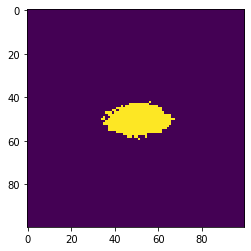

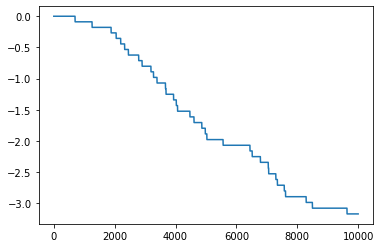

349.0
0.0


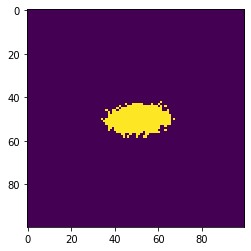

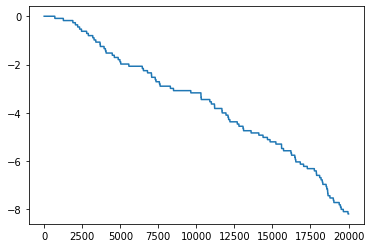

344.0
0.0


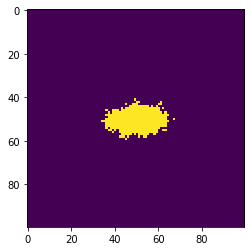

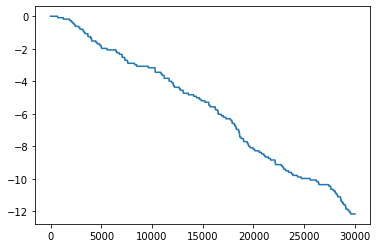

334.0
0.0


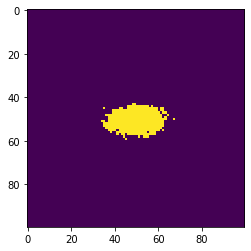

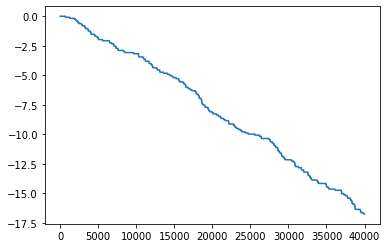

335.0
0.0


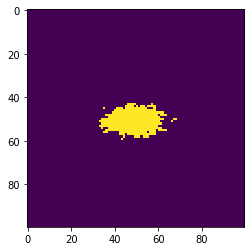

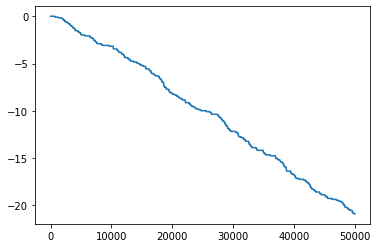

348.0
0.0


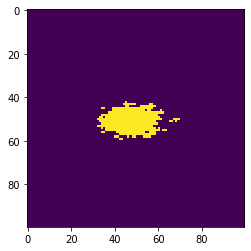

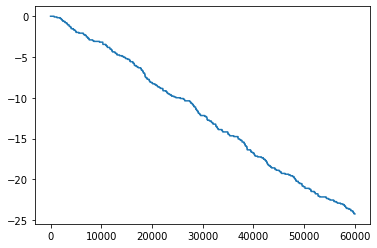

341.0
0.0


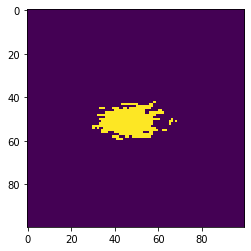

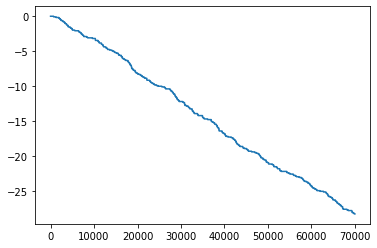

354.0
0.0


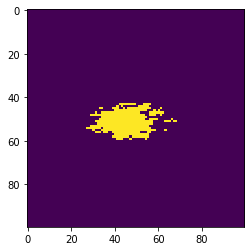

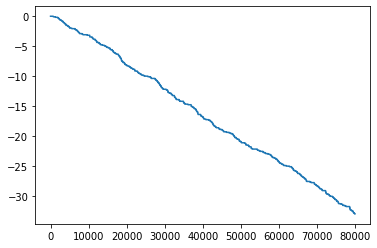

366.0
0.0


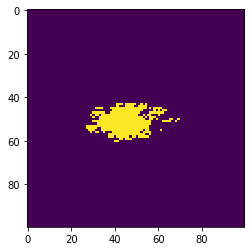

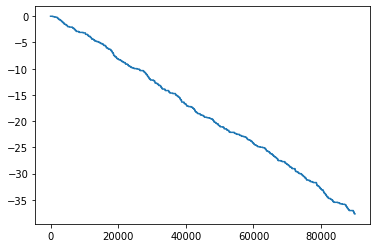

371.0
0.0


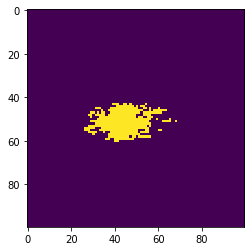

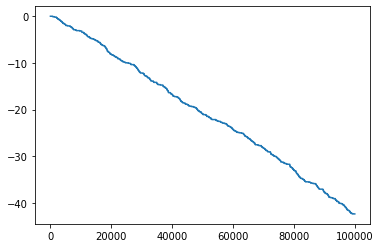

370.0
0.0


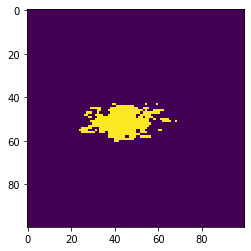

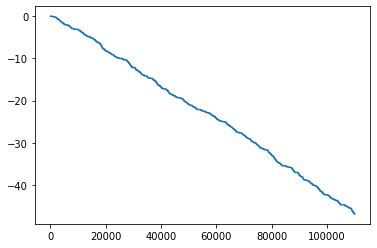

367.0
0.0


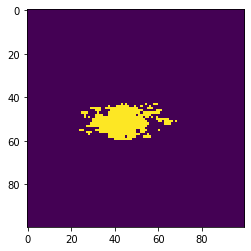

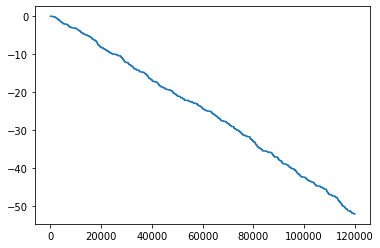

370.0
0.0


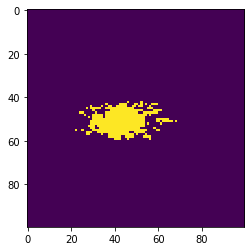

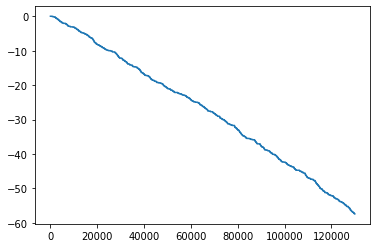

361.0
0.0


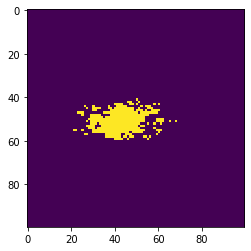

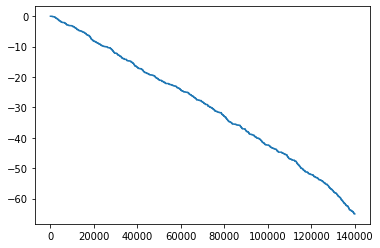

370.0
0.0


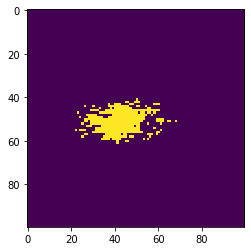

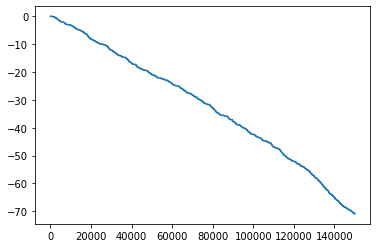

375.0
0.0


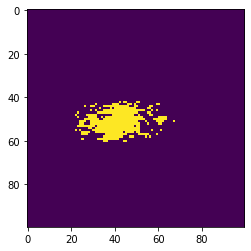

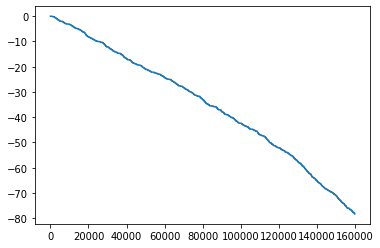

388.0
0.0


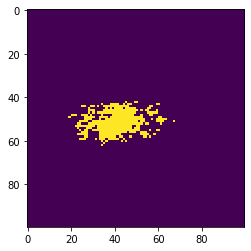

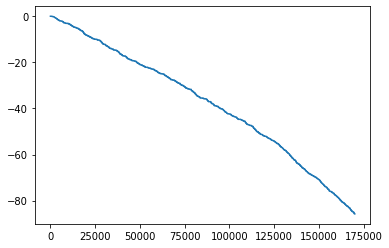

412.0
0.0


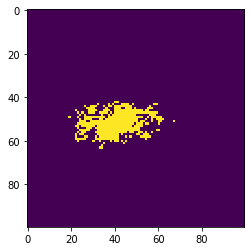

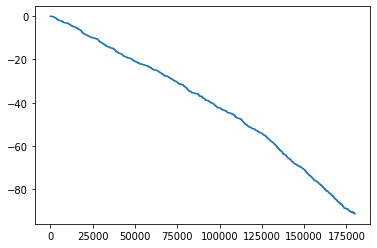

399.0
0.0


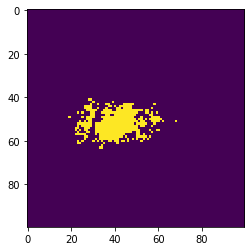

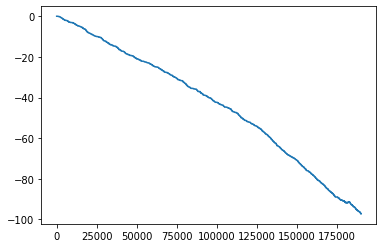

367.0
0.0


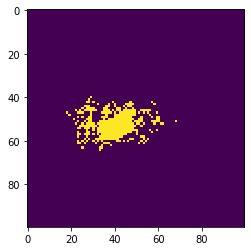

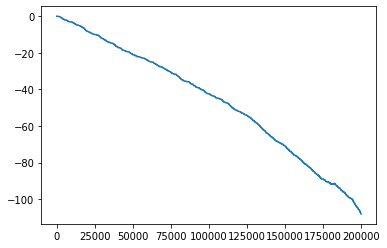

In [8]:
# import tensorflow as tf
import numpy as np
import random

A0 = 430
P0 = 74

alpha = 1
beta = 0.0005
gamma_beta = 1
gamma_alpha = 0

NUM_ACTIONS = 8
training_steps = 20

all_rewards = []

a = 3
run_rewards = []

grid = Grid2D(100,100,0.15)

batch_size = 64

agent = DQNAgent([100,100,1], 8)

grid_shape = grid.get_shape()
ind_1 = np.random.randint(grid_shape[0])
ind_2 = np.random.randint(grid_shape[1])

(xv,yv) = np.meshgrid(list(range(ind_1-1,ind_1+2)),list(range(ind_2-1,ind_2+2)))
xv = xv.flatten().tolist()
yv = yv.flatten().tolist()

del xv[4]
del yv[4]
boundary_inds = np.logical_or(np.logical_or(np.logical_or(xv == -1, yv == -1), xv == grid.get_shape()[0]), yv == grid.get_shape()[1])

boundaries = grid.return_boundary_cells_grid(grid.grid.copy(),ind_1,ind_2)
boundaries = grid.tile_coding(boundaries.copy(),a,a)
boundaries[ind_1,ind_2] = 2
boundaries = boundaries.reshape((1,grid.grid.shape[0],grid.grid.shape[1],1))
episode_reward = 0
tot_rewards = []

action = np.random.randint(0,NUM_ACTIONS)
ims = []
ims.append(grid.grid)


for i in range(training_steps):
    for j in range(grid_shape[0]*grid_shape[1]):
        xv = np.array(xv)
        yv = np.array(yv)

        newgrid = grid.grid.copy()
        old = newgrid[ind_1,ind_2]

        boundary_inds = np.logical_or(np.logical_or(np.logical_or(xv == -1, yv == -1), xv == grid.grid.shape[0]), yv == grid.grid.shape[1])

        boundary_inds_inv = list(map(operator.not_, boundary_inds.tolist()))
        test_xv = xv[boundary_inds_inv]
        test_yv = yv[boundary_inds_inv]

        test_values = []
        for k in range(len(test_xv)):
            test_values.append(grid.grid[test_xv[k],test_yv[k]])

        if(~np.all(np.array(test_values) == test_values[0])):
            action = agent.act(boundaries)
            if(xv[action] == -1 or xv[action] == grid.get_shape()[0] or yv[action] == -1 or yv[action] == grid.get_shape()[1]):
                reward = 0
            elif(old != newgrid[xv[action],yv[action]]):
                newgrid[ind_1,ind_2] = newgrid[xv[action],yv[action]]            

                U1, U2, diff, reward = grid.get_U_diff(grid.grid.copy(), newgrid.copy(), alpha, beta, gamma_alpha, gamma_beta, A0, P0)

                grid.grid = newgrid.copy()
                grid.perims = grid.cand_p
                grid.areas = grid.cand_a

                next_state = grid.return_boundary_cells_grid(newgrid.copy(),prev_ind_1,prev_ind_2).reshape((1,grid.grid.shape[0],grid.grid.shape[1],1))
                next_state = grid.tile_coding(next_state.copy(),a,a)
                next_state[0,prev_ind_1,prev_ind_2,0] = 2
                agent.memorize(boundaries, action, reward*100, next_state, [ind_1,ind_2], False)
                episode_reward += reward     

                if len(agent.memory) > batch_size:
                    agent.replay(batch_size)

        else:
            reward = 0

        prev_ind_1 = ind_1
        prev_ind_2 = ind_2

        ind_1 = np.random.randint(grid_shape[0])
        ind_2 = np.random.randint(grid_shape[1])

        (xv,yv) = np.meshgrid(list(range(ind_1-1,ind_1+2)),list(range(ind_2-1,ind_2+2)))
        xv = xv.flatten().tolist()
        yv = yv.flatten().tolist()

        del xv[4]
        del yv[4]

        new_boundaries = grid.return_boundary_cells_grid(grid.grid.copy(),ind_1,ind_2)
        new_boundaries = grid.tile_coding(new_boundaries.copy(),a,a)
        new_boundaries[ind_1,ind_2] = 2
        new_boundaries = new_boundaries.reshape((1,grid.grid.shape[0],grid.grid.shape[1],1))

        tot_rewards.append(episode_reward)

        boundaries = new_boundaries
    agent.update_target_model()
    print(np.mean(grid.areas))
    print(np.var(grid.areas))
    xs,ys = np.where(newgrid)
    
    plt.imshow(grid.grid)
    plt.show()
    plt.plot(tot_rewards)
    plt.show()
    ims.append(grid.grid)

run_rewards.append(tot_rewards)
all_rewards.append(np.mean(run_rewards,0))

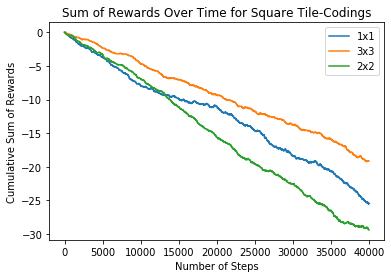

In [44]:
plt.plot(all_rewards[0])
plt.plot(all_rewards[1])
plt.plot(all_rewards[2])
plt.legend({'1x1','2x2','3x3'})
plt.title('Sum of Rewards Over Time for Square Tile-Codings')
plt.ylabel('Cumulative Sum of Rewards')
plt.xlabel('Number of Steps')
plt.show()

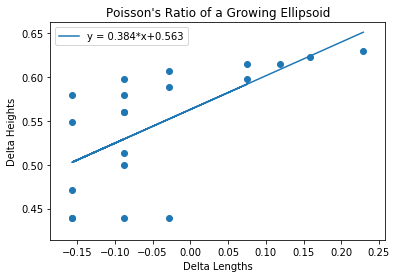

In [26]:
plt.scatter(heights,lengths)
m, b = np. polyfit(heights, lengths, 1) 
plt.xlabel('Delta Lengths')
plt.ylabel('Delta Heights')
plt.title('Poisson\'s Ratio of a Growing Ellipsoid')
plt. plot(heights, m*np.array(heights) + b)
plt.legend({'y = 0.384*x+0.563'})
plt.show()

In [22]:
import cv2
for i in range(len(ims)):
    cv2.imwrite('/media/mattonics/desk86/RL_CM/RL_CM1_Images/' + str(i) + '.png',ims[i])

0.562928365617794

In [7]:
import operator
import numpy as np

class TestGrid2D(): 
    def __init__(self,x_dim,y_dim):
        self.grid = np.zeros((y_dim,x_dim))
        self.velocities = []
        
        for i in range(y_dim):
            for j in range(x_dim):
                if((50 - i)**2/7.5**2 + (50 - j)**2/16**2 <= 1):
                    self.grid[i,j] = 1
                    
        num_cells = int(self.grid.flatten().max())
        areas = []
        for i in range(1,num_cells+1):
            areas.append(self.get_area(self.grid,i))
        self.areas = areas
        
        self.num_cells = num_cells
        
        perims = []
        for i in range(1,num_cells+1):
            perims.append(self.get_perimeter(self.grid,i))
            
        self.perims = perims
        
        self.cand_a = areas
        self.cand_p = perims
        
    def return_updated_area_grid(self, grid, ind_i, ind_j):
        xv = np.array([ind_i-1,ind_i+1,ind_i,ind_i,ind_i+1,ind_i+1,ind_i-1,ind_i-1])
        yv = np.array([ind_j,ind_j,ind_j-1,ind_j+1,ind_j+1,ind_j-1,ind_j+1,ind_j-1])
        boundary_inds = np.logical_or(np.logical_or(np.logical_or(xv == -1, yv == -1), xv == self.grid.shape[0]), yv == self.grid.shape[1])

        boundary_inds_inv = list(map(operator.not_, boundary_inds))
        xv = xv[boundary_inds_inv]
        yv = yv[boundary_inds_inv]
        
        cell_array = []
        for i in range(len(xv)):
            x = xv[i]
            y = yv[i]
            cell_array.append(grid[x,y])
        cell_array = np.unique(cell_array).tolist()
        
        if(0 in cell_array):
            cell_array.remove(0)
        
        boundary_grid = grid.copy() != 0
        
        area_grid = self.area_grid
        
        for cell in cell_array:
            area_grid[np.array(grid == cell)] = self.areas[int(cell-1)]
            
        return area_grid
            
    def _boundarize_grid(self, grid):
        boundaries = np.zeros(grid.shape)
        (i_inds,j_inds) = np.where(grid)
        boundary_points = []
        for i in range(len(i_inds)):
            if (i_inds[i] == 0 or i_inds[i] == grid.shape[0] - 1 or j_inds[i] == 0 or j_inds[i] == grid.shape[1] - 1):
                boundary_points.append([i_inds[i],j_inds[i]])
            neighborhood = grid[i_inds[i]-1:i_inds[i]+2,j_inds[i]-1:j_inds[i]+2]
            
            if ((neighborhood.flatten() == 0).any()):
                boundary_points.append([i_inds[i],j_inds[i]])                
        
        boundary_points = np.array(boundary_points)
        for x in boundary_points:
            boundaries[x[0],x[1]] = 1
        return boundaries
    
    def return_boundaries(self, grid, newgrid):
        
        diff_grid = grid - newgrid
        diff_inds = np.where(diff_grid != 0)
        
        diff_cells = grid[diff_inds]
        diff_cell_inds = np.where(diff_cells != 0)
        diff_cells = diff_cells[diff_cell_inds]
        
        new_diff_cells = newgrid[diff_inds]
        new_diff_cell_inds = np.where(new_diff_cells != 0)
        new_diff_cells = new_diff_cells[new_diff_cell_inds]
        
        diff_cells = np.unique(np.append(diff_cells,new_diff_cells))
        
        boundary_grid = np.zeros(grid.shape)
        for cell in diff_cells:
            boundary_i = grid == cell
            boundary_grid = np.add(boundary_grid, self._boundarize_grid(boundary_i))
        
        boundary_newgrid = np.zeros(grid.shape)
        for cell in diff_cells:
            boundary_i = newgrid == cell
            boundary_newgrid = np.add(boundary_newgrid, self._boundarize_grid(boundary_i))
                
        return np.append(boundary_grid,boundary_newgrid).flatten()
    
    def get_perimeter(self, grid, i):

        index_grid = grid == i
        i_inds,j_inds = np.where(index_grid)
        
        perim_pixels = 0
        for i in range(len(i_inds)):
            ind_1 = i_inds[i]
            ind_2 = j_inds[i]
            xv = np.array([ind_1-1,ind_1+1,ind_1,ind_1])
            yv = np.array([ind_2,ind_2,ind_2-1,ind_2+1])
            boundary_inds = np.logical_or(np.logical_or(np.logical_or(xv == -1, yv == -1), xv == self.grid.shape[0]), yv == self.grid.shape[1])
            
            for j in range(len(boundary_inds)):
                if(boundary_inds[j] == True):
                    perim_pixels += 1
                    
            boundary_inds_inv = list(map(operator.not_, boundary_inds))
            xv = xv[boundary_inds_inv]
            yv = yv[boundary_inds_inv]
            
            for j in range(len(xv)):
                if(index_grid[xv[j],yv[j]] == 0):
                    perim_pixels += 1
                    
        
        return perim_pixels
    
    def get_area(self, grid, i):
        index_grid = grid == i
        
        return (np.sum(index_grid.flatten()))
    
    def compute_energy(self, grid, areas, perims, alpha, beta, gamma_alpha, gamma_beta, A0, P0):
        a_diff = np.sum(np.power((np.array(areas) - A0),2)).astype(int)
        p_diff = np.sum(np.power((np.array(perims) - P0),2)).astype(int)
        
        U = a_diff + p_diff
            
        return U, a_diff, p_diff
    
    def get_U_diff(self, grid, newgrid, alpha, beta, gamma_alpha, gamma_beta, A0, P0):
        
        U1,grid_a_diff,grid_p_diff = self.compute_energy(grid,self.areas, self.perims, alpha,beta,gamma_alpha, gamma_beta,A0,P0)
        
        diff_grid = grid - newgrid
        diff_inds = np.where(diff_grid != 0)
        
        diff_cells = grid[diff_inds]
        diff_cell_inds = np.where(diff_cells != 0)
        diff_cells = diff_cells[diff_cell_inds]
        
        new_diff_cells = newgrid[diff_inds]
        new_diff_cell_inds = np.where(new_diff_cells != 0)
        new_diff_cells = new_diff_cells[new_diff_cell_inds]
        
        diff_cells = np.unique(np.append(diff_cells,new_diff_cells))
        
        self.cand_a = self.areas.copy()
        self.cand_p = self.perims.copy()
        
        for cell in diff_cells:
            cell = int(cell)
            self.cand_a[cell-1] = self.get_area(newgrid, cell)
            self.cand_p[cell-1] = self.get_perimeter(newgrid, cell)
            
        U2,newgrid_a_diff,newgrid_p_diff = self.compute_energy(newgrid,self.cand_a,self.cand_p,alpha,beta,gamma_alpha, gamma_beta,A0,P0)    
        
        reward = 0
        
        diff = grid_a_diff - newgrid_a_diff
        
        if(diff > 0):
            reward += alpha*st.betaprime.pdf(2,1,diff/10 + 1/2)
        else:
            reward += alpha*np.arctan(diff/25)/15
        
        diff = grid_p_diff - newgrid_p_diff
        
        if(diff > 0):
            reward += beta*st.betaprime.pdf(2,1,diff/10 + 1/2)
        else:
            reward += beta*np.arctan(diff/25)/15
            
        
        return U1, U2, U1 - U2, reward
    
    def get_persistences(self, grid, newgrid, alpha, beta):
        
        p = 0
        
        diff_grid = grid - newgrid
        diff_inds = np.where(diff_grid != 0)
        
        diff_cells = grid[diff_inds]
        diff_cell_inds = np.where(diff_cells != 0)
        diff_cells = diff_cells[diff_cell_inds]
        
        new_diff_cells = newgrid[diff_inds]
        new_diff_cell_inds = np.where(new_diff_cells != 0)
        new_diff_cells = new_diff_cells[new_diff_cell_inds]
        
        diff_cells = np.unique(np.append(diff_cells,new_diff_cells))
        
        for cell in diff_cells:
            cell = int(cell)
            p += self.get_persistence(grid, newgrid, cell - 1, alpha, beta)
            
        return p
    
    def get_persistence(self, grid, newgrid, i, alpha, beta):
        s = [0,0]        
        if (self.velocities == []):
            return 0
        
        for j in range(len(self.velocities)):
            s += np.exp(-beta*(len(self.velocities) - j))*self.velocities[j][i]
        if (np.linalg.norm(s) != 0):
            preceding_dir = s/np.linalg.norm(s)
        else:
            preceding_dir = [0,0]
        
        grid_i = grid == i + 1
        newgrid_i = newgrid == i + 1
                
        (grid_x,grid_y) = np.where(grid_i)
        (newgrid_x,newgrid_y) = np.where(newgrid_i)
        
        if (len(grid_x) == 0 or len(newgrid_x) == 0):
            return 0
        
        grid_x = np.mean(grid_x)
        grid_y = np.mean(grid_y)
        
        newgrid_x = np.mean(newgrid_x)
        newgrid_y = np.mean(newgrid_y)
        
        direction = np.array([newgrid_x,newgrid_y]) - np.array([grid_x,grid_y])
        if (np.linalg.norm(direction) != 0):
            direction = direction/np.linalg.norm(direction)
        
        return alpha * np.dot(preceding_dir, direction)
    
    def append_velocities(self, grid, newgrid):
        
        grid_centroids = []
        for i in range(1,int(self.num_cells)+1):
            cell_grid = grid == i
            nx,ny = np.where(cell_grid)
            grid_centroids.append([np.mean(nx),np.mean(ny)])
        
        newgrid_centroids = []
        for i in range(1,int(self.num_cells+1)):
            cell_grid = newgrid == i
            nx,ny = np.where(cell_grid)
            newgrid_centroids.append([np.mean(nx),np.mean(ny)])
        
        self.velocities.append(np.subtract(newgrid_centroids, grid_centroids))
    
    def get_shape(self):
        return self.grid.shape
    
    def return_bounding(self, grid, ind_i, ind_j, buffer):
        low_i_bound = ind_i - buffer
        high_i_bound = ind_i + buffer
        
        pad_i_up = -1*min([0,low_i_bound])
        low_i_bound = max([0,low_i_bound])
        pad_i_down = -1*min([0,grid.shape[0] - high_i_bound - 1])
        high_i_bound = min([high_i_bound,grid.shape[0] - 1])
        
        
        low_j_bound = ind_j - buffer
        high_j_bound = ind_j + buffer
        
        pad_j_up = -1*min([0,low_j_bound])
        low_j_bound = max([0,low_j_bound])
        pad_j_down = -1*min([0,grid.shape[1] - high_j_bound - 1])
        high_j_bound = min([high_j_bound,grid.shape[1] - 1])
        
        raw = grid[int(low_i_bound):int(high_i_bound),int(low_j_bound):int(high_j_bound)]
        
        return np.pad(raw, ((int(pad_i_up),int(pad_i_down)),(int(pad_j_up),int(pad_j_down))),'constant',constant_values=0)
        
    def return_boundary_cells_grid(self, grid, ind_i, ind_j):
        xv = np.array([ind_i-1,ind_i+1,ind_i,ind_i,ind_i+1,ind_i+1,ind_i-1,ind_i-1])
        yv = np.array([ind_j,ind_j,ind_j-1,ind_j+1,ind_j+1,ind_j-1,ind_j+1,ind_j-1])
        boundary_inds = np.logical_or(np.logical_or(np.logical_or(xv == -1, yv == -1), xv == self.grid.shape[0]), yv == self.grid.shape[1])

        boundary_inds_inv = list(map(operator.not_, boundary_inds))
        xv = xv[boundary_inds_inv]
        yv = yv[boundary_inds_inv]
        
        cell_array = []
        for i in range(len(xv)):
            x = xv[i]
            y = yv[i]
            cell_array.append(grid[x,y])
        cell_array = np.unique(cell_array).tolist()
        
        if(0 in cell_array):
            cell_array.remove(0)
        
        boundary_grid = np.zeros(self.grid.shape)
        
        
        for cell in cell_array:
            boundary_grid = np.add(self._boundarize_grid(grid == cell),boundary_grid)
        
        return boundary_grid
    
    def get_perimeter_2(self, grid, i):
        
        boundary_i = grid == i
                
        return np.sum(self._boundarize_grid(boundary_i))
    
    def return_entire_boundary(self, grid):
        boundary_grid = np.zeros(self.grid.shape)
        for cell in range(1,self.num_cells+1):
            boundary_i = grid == cell
            boundary_grid = np.add(boundary_grid, self._boundarize_grid(boundary_i))
            
        return boundary_grid
    
        
    def tile_coding(self, grid, a, b):
        padded_grid = np.pad(grid,(a-1,b-1))
        new_grid = np.zeros(grid.shape)
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                if ((padded_grid[i:i+a,j:j+b] != 0).any()):
                    new_grid[i,j] = 1
        return new_grid